<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/rosario/pneumonia_playaround_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np

import os
from glob import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.utils import get_file
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [2]:
! pip install -q kaggle
from google.colab import files

In [3]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rosarioaraujo1","key":"693fda2ac8b5acb6d226a01effb49e1e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:43<00:00, 49.4MB/s]
100% 2.29G/2.29G [00:43<00:00, 56.2MB/s]


In [6]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

In [8]:
!ls

chest-xray-pneumonia.zip  files  kaggle.json  sample_data


# X-ray Image Classification 

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using Convolutional Neural Networks. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle.


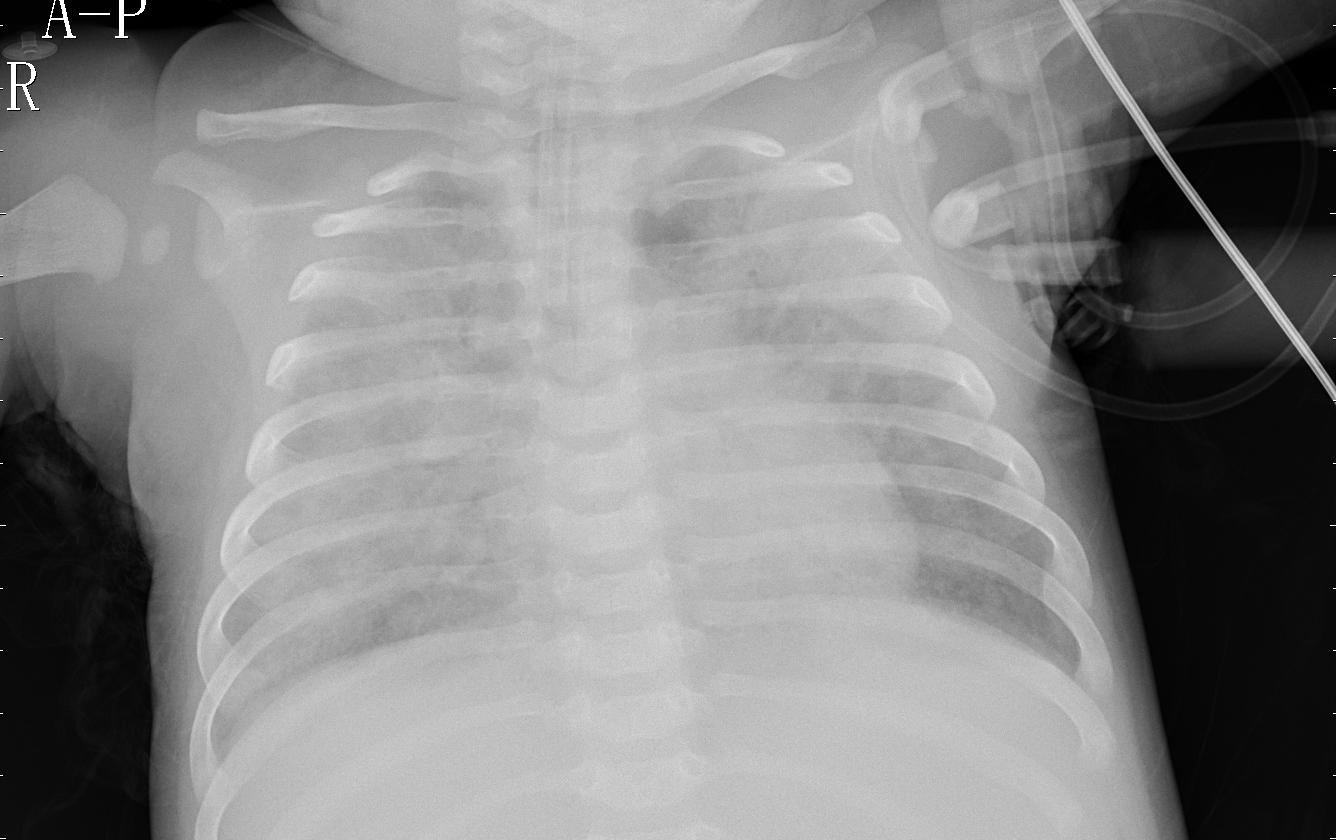

In [9]:
# The local path to the target image
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

display(Image(img_path))

Stuff about preprocessing

# Binary Classification

For our first model, we will first take the images from our drive, and preprocess them into data that can be fed into a CNN.

For this section, we will focus on predicting whether a patient has pneumonia or not.

In [10]:
def load_data(path):

  imgs = []
  labels = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])
      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  return imgs, labels


In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [11]:
X_train, y_train = load_data("/content/files/chest_xray/train")
X_test, y_test = load_data("/content/files/chest_xray/test")

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0


##Transfer Learning 





In [70]:
img_size = [224,224]

train_path = "/content/files/chest_xray/train"
test_path = "/content/files/chest_xray/test"


vgg = VGG16(input_shape=img_size + [3], weights='imagenet', include_top=False)


for layer in vgg.layers:
  layer.trainable = False

folders = glob('/content/files/chest_xray/train*/')

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)


model.summary()


Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [74]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [75]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/files/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32)

test_set = test_datagen.flow_from_directory('/content/files/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32)

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [78]:
history = model.fit(training_set,steps_per_epoch=len(training_set),epochs=20,validation_data=test_set,validation_steps=len(test_set))

Epoch 1/20
163/163 [==============================] - 94s 578ms/step - loss: 0.8607 - accuracy: 0.8315 - val_loss: 0.8308 - val_accuracy: 0.8739
Epoch 2/20
163/163 [==============================] - 94s 577ms/step - loss: 0.9145 - accuracy: 0.8194 - val_loss: 0.9805 - val_accuracy: 0.7869
Epoch 3/20
163/163 [==============================] - 94s 576ms/step - loss: 0.8592 - accuracy: 0.8341 - val_loss: 1.0322 - val_accuracy: 0.7682
Epoch 4/20
163/163 [==============================] - 94s 576ms/step - loss: 0.8290 - accuracy: 0.8335 - val_loss: 0.8574 - val_accuracy: 0.8232
Epoch 5/20
163/163 [==============================] - 94s 577ms/step - loss: 0.8389 - accuracy: 0.8358 - val_loss: 0.6491 - val_accuracy: 0.9022
Epoch 6/20
163/163 [==============================] - 94s 574ms/step - loss: 0.7835 - accuracy: 0.8412 - val_loss: 0.6940 - val_accuracy: 0.9033
Epoch 7/20
163/163 [==============================] - 94s 576ms/step - loss: 0.7820 - accuracy: 0.8432 - val_loss: 0.5452 - val_ac

## CNN

We will be testing our data on a simple CNN, with a dropout rate of 0.5 to prevent overfitting.

In [13]:
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# f1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

Because this is a binaru classification problem, the imbalance in our data can easily be circumvented by weighting our classes individually, in proportion to the amount of instances of pneumonia there are.

In [17]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1]}
print(class_weights)

[1.9448173  0.67303226]
{0: 1.9448173005219984, 1: 0.6730322580645162}


In order to improve the accuracy of our model, we will be generating data on the fly.

Again, to prevent overfitting, we have an early stopping callback in our training

In [18]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

# todo: early stopping callback

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size,class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 22s 134ms/step - loss: 0.6529 - accuracy: 0.6221 - f1_m: 0.6367 - precision_m: 0.7335 - recall_m: 0.6250 - val_loss: 0.7125 - val_accuracy: 0.6908 - val_f1_m: 0.7959 - val_precision_m: 0.6722 - val_recall_m: 0.9839
Epoch 2/20
163/163 [==============================] - 22s 132ms/step - loss: 0.5129 - accuracy: 0.7421 - f1_m: 0.7903 - precision_m: 0.9144 - recall_m: 0.7315 - val_loss: 0.6954 - val_accuracy: 0.6727 - val_f1_m: 0.6435 - val_precision_m: 0.9828 - val_recall_m: 0.4834
Epoch 3/20
163/163 [==============================] - 22s 132ms/step - loss: 0.4503 - accuracy: 0.7841 - f1_m: 0.8285 - precision_m: 0.9325 - recall_m: 0.7705 - val_loss: 0.4138 - val_accuracy: 0.8191 - val_f1_m: 0.8443 - val_precision_m: 0.8931 - val_recall_m: 0.8064
Epoch 4/20
163/163 [==============================] - 22s 133ms/step - loss: 0.4036 - accuracy: 0.8129 - f1_m: 0.8533 - precision_m: 0.9432 - recall_m: 0.8025 - val_loss: 0.4737 - val_accuracy:

Trainining our model gives us around an 82% accuracy in regards to predicting whether a patient has pneumonia or not.

In [19]:
model.evaluate_generator(gen_test, 50, workers=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.2971643805503845,
 0.8605769276618958,
 0.8794686198234558,
 0.9181919097900391,
 0.8491106033325195]

In [20]:
'''
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Chance of Pneumonia:", (preds))
'''

'\nfor i in range (0, 400):\n  preds = model.predict(np.expand_dims(X_test[i], axis=0))\n  print("Chance of Pneumonia:", (preds))\n'

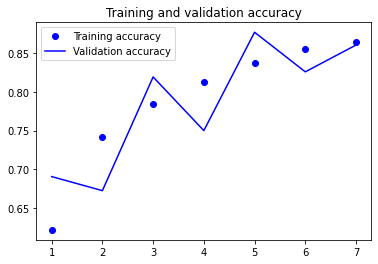

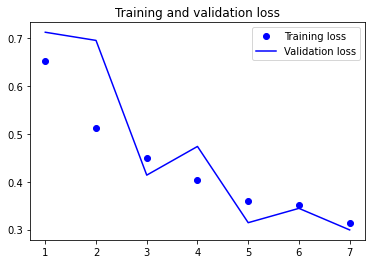

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

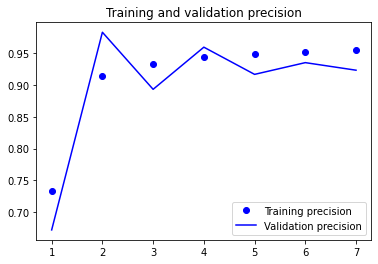

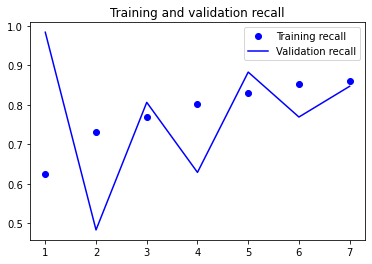

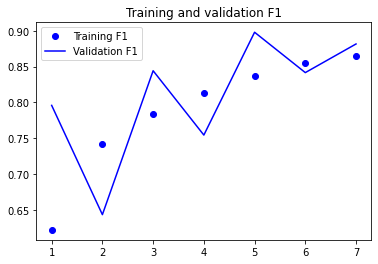

In [22]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

We will fetch two images from our test directory to test our model's prediction-making ability.

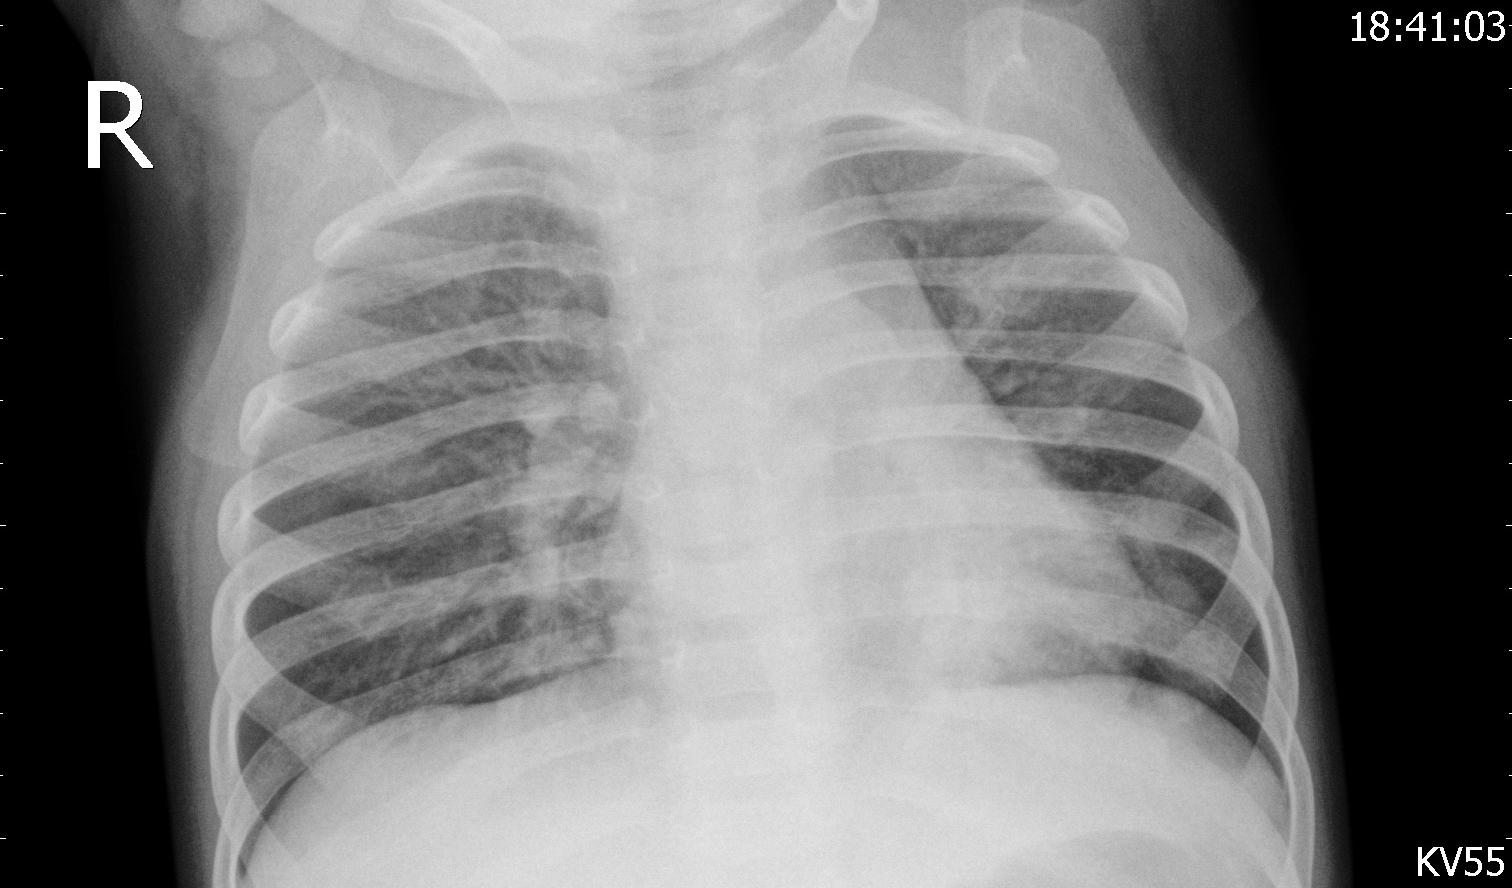

Chance of Pneumonia: [[0.9042775]]


In [23]:
img_path = "/content/files/chest_xray/test/PNEUMONIA/person1671_virus_2887.jpeg"

display(Image(img_path))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
img = x

preds = model.predict(img)


print("Chance of Pneumonia:", (preds))

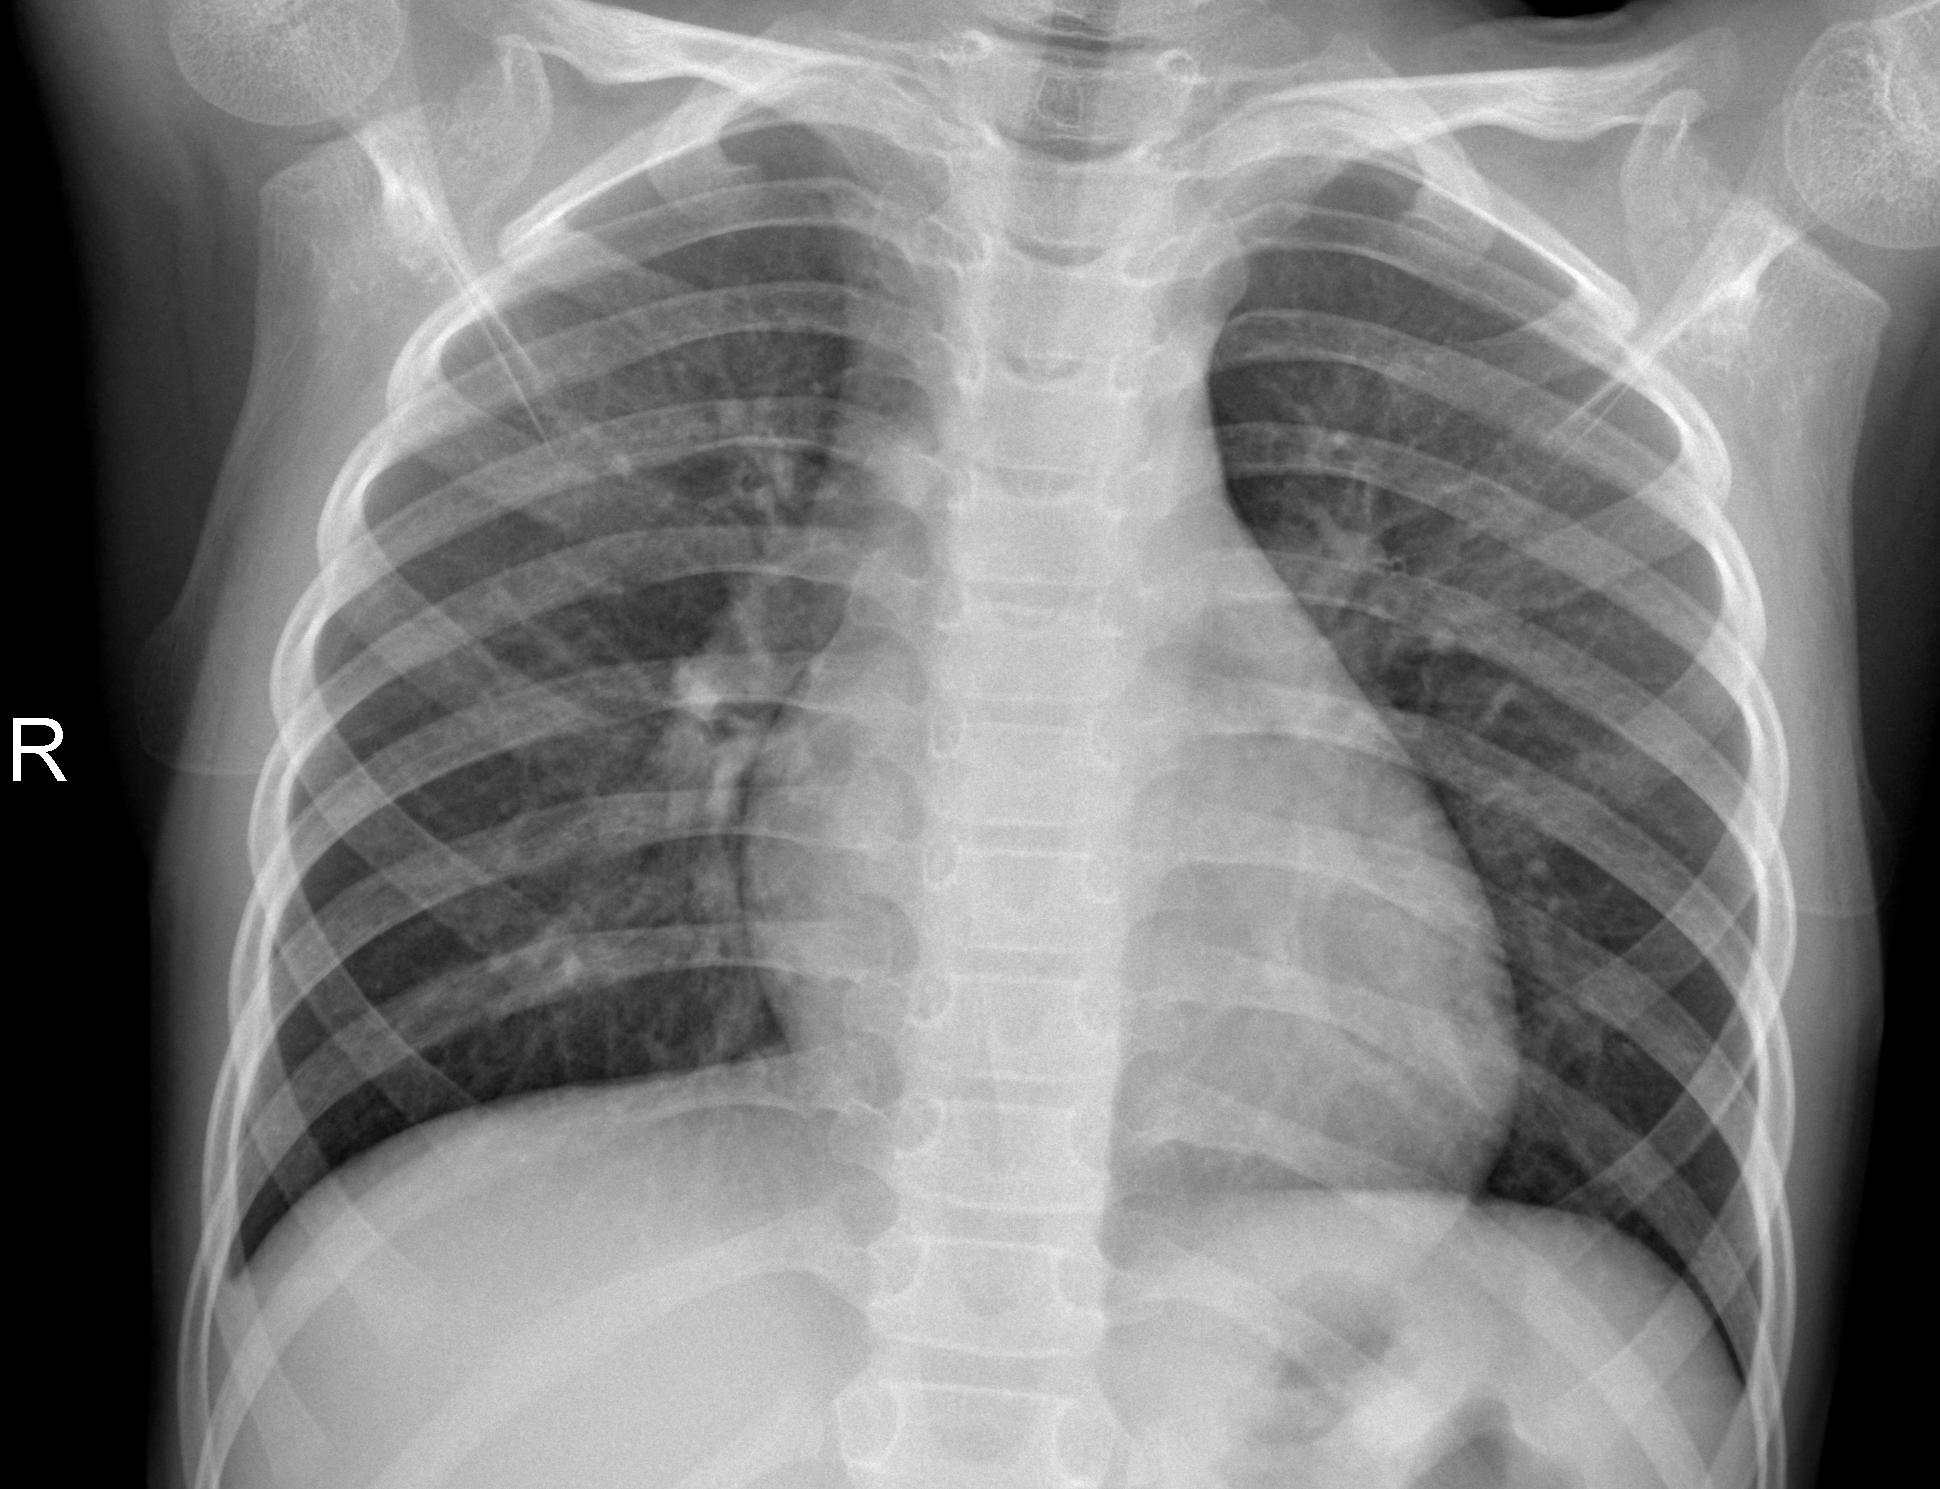

Chance of Pneumonia: [[0.02232354]]


In [24]:
img_path = "/content/files/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg"

display(Image(img_path))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
img = x

preds = model.predict(img)


print("Chance of Pneumonia:", (preds))

This program predicts with 98% certainty that this patient has pneumonia.

We will now see what our model focuses on in when predicting a pneumonia case.

##Imbalanced Data
(placeholder for the time being)

In [25]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1]}
print(class_weights)

[1.9448173  0.67303226]
{0: 1.9448173005219984, 1: 0.6730322580645162}


In [26]:
!pip install imblearn 

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

#X_train_S, y_train_S = smote.fit_sample(X_train,y_train)


print(X_train[1])

[[[0.00784314 0.00784314 0.00784314]
  [0.0627451  0.0627451  0.0627451 ]
  [0.11372549 0.11372549 0.11372549]
  ...
  [0.13725491 0.13725491 0.13725491]
  [0.10588235 0.10588235 0.10588235]
  [0.07058824 0.07058824 0.07058824]]

 [[0.         0.         0.        ]
  [0.05098039 0.05098039 0.05098039]
  [0.10980392 0.10980392 0.10980392]
  ...
  [0.12156863 0.12156863 0.12156863]
  [0.10980392 0.10980392 0.10980392]
  [0.07843138 0.07843138 0.07843138]]

 [[0.         0.         0.        ]
  [0.03529412 0.03529412 0.03529412]
  [0.10196079 0.10196079 0.10196079]
  ...
  [0.10588235 0.10588235 0.10588235]
  [0.09019608 0.09019608 0.09019608]
  [0.05882353 0.05882353 0.05882353]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [28]:
from collections import Counter
print(Counter(y_train_S))

NameError: ignored

# HEAT MAPS!

We will be borrowing the Grad-CAM code on Keras's website for our following visuals.

source: https://keras.io/examples/vision/grad_cam/

In [29]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array /= 255
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def superimposition(img_path, heatmap, save_img_as):
  img = image.load_img(img_path)
  img = image.img_to_array(img)

  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = image.array_to_img(superimposed_img)

  save_path = save_img_as
  superimposed_img.save(save_path)

  # Display Grad CAM
  display(Image(save_path))

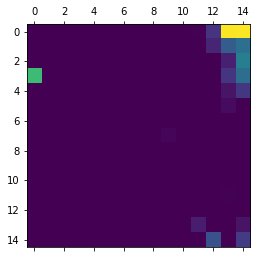

In [30]:
img_path = "/content/files/chest_xray/test/PNEUMONIA/person1671_virus_2887.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

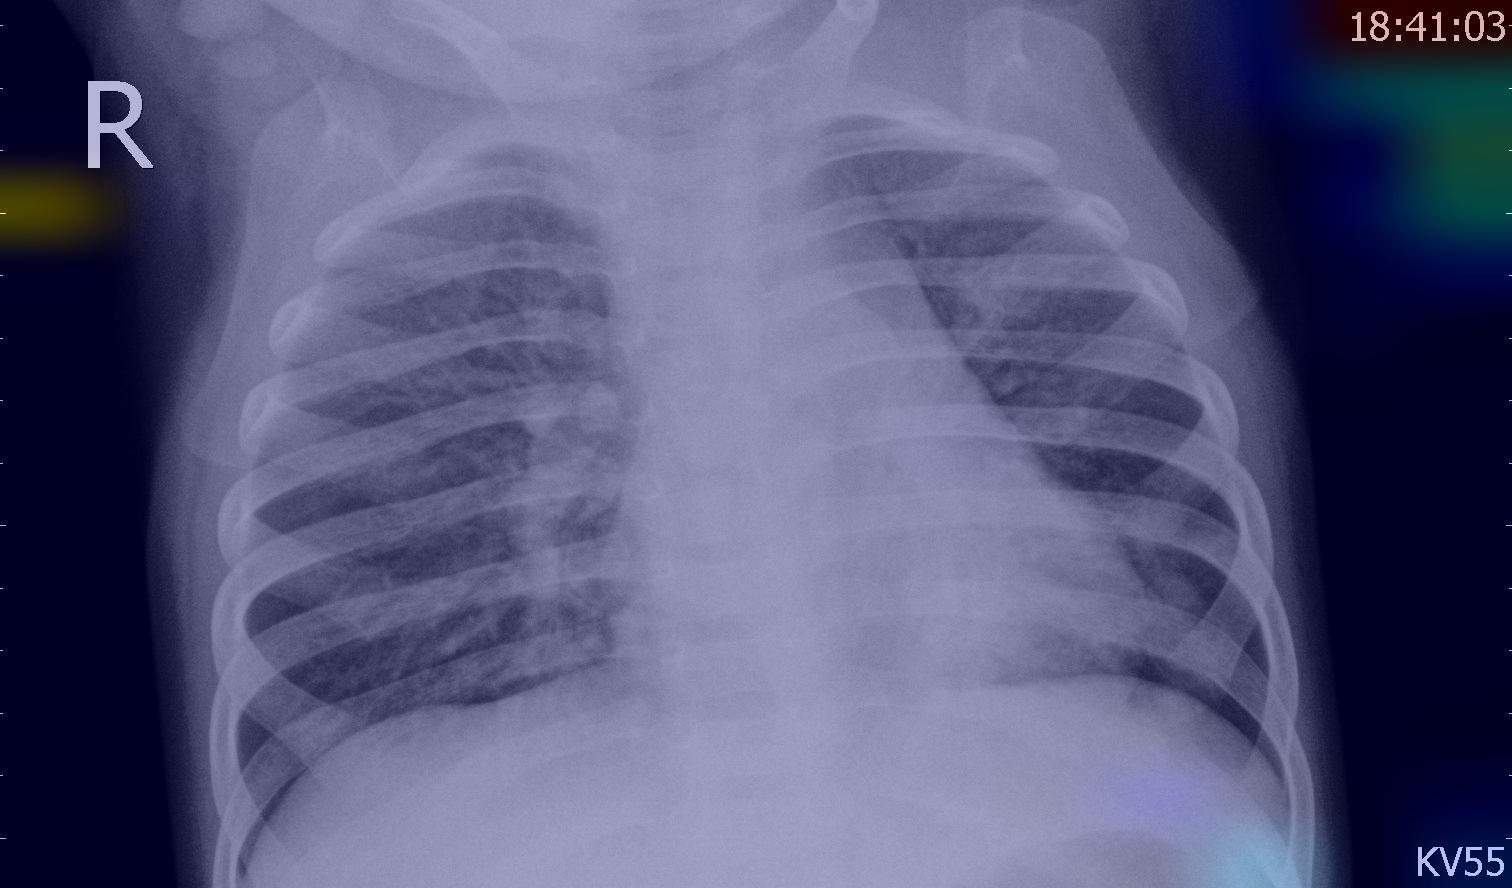

In [31]:
superimposition("/content/files/chest_xray/test/PNEUMONIA/person1671_virus_2887.jpeg", heatmap, "binary_pneumonia_case.jpeg")

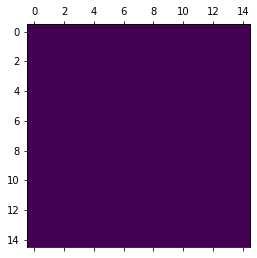

In [32]:
img_path = "/content/files/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

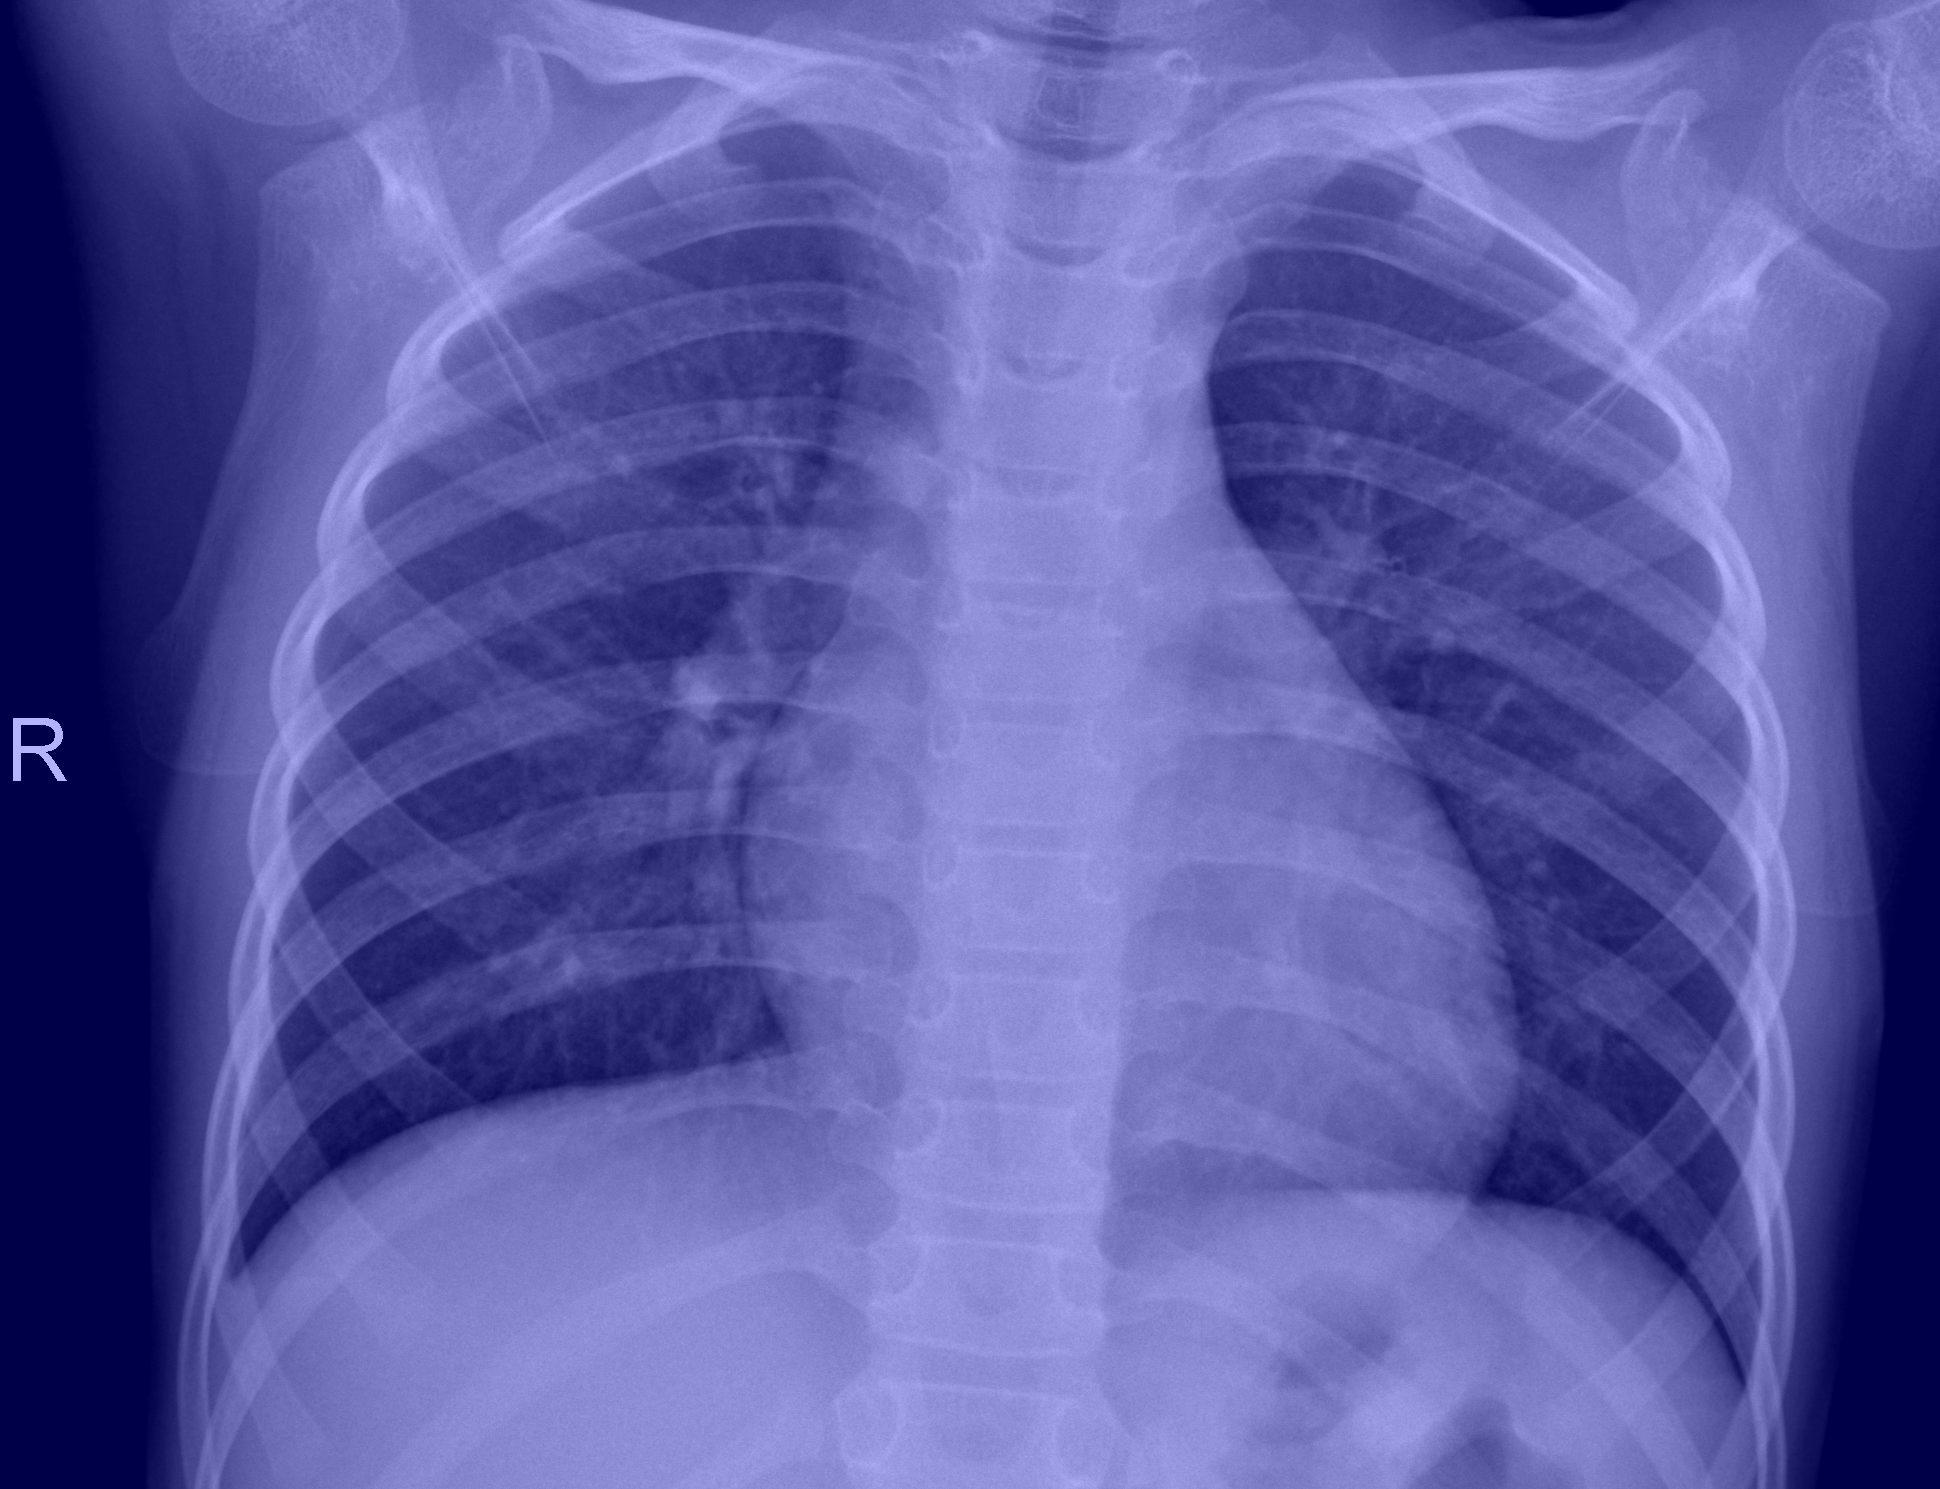

In [33]:
superimposition("/content/files/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg", heatmap, "binary_normal_case.jpeg")

The superimposed heatmap lights up in the patients' chest cavity, showing where in the picture this model focuses on.
 
 (todo: a non-pneumonia pic)

# Three-Way Classification

We will now be processing our data such that we will also be taking into consideration, the type of pneumonia one can be diagnosed with -- bacterial and viral.

In [34]:
def load_data_2(path):
  imgs = []
  labels = []

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)

      # one-hot encoded labels
      labels.append([int(not ('bacteria' in f or 'virus' in f)), int('bacteria' in f), int('virus' in f)])


      # to check progress:
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1

      

  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels

In [35]:
X_train, y_train = load_data_2("/content/files/chest_xray/train")
X_test, y_test = load_data_2("/content/files/chest_xray/test")
print(y_test)

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


We will now prepare our dataset for easy photo access for our cluster analysis.

In [36]:
# prepare three-way categorical data directories for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data directories for testing
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..

/content/files/chest_xray/train
/content/files/chest_xray/train/PNEUMONIA
/content/files/chest_xray/train
BACTERIA  NORMAL  VIRUS
/content/files/chest_xray/test
/content/files/chest_xray/test/PNEUMONIA
/content/files/chest_xray/test
/content


In [37]:
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
'''

'\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img\n\nbatch_size = 128\n\ntraingen = ImageDataGenerator(\n    rescale= 1./255,\n    rotation_range =45,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip = True\n\n)\n\ntestgen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = traingen.flow_from_directory(\n        "/content/files/chest_xray/train",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\nvalidation_generator = testgen.flow_from_directory(\n        "/content/files/chest_xray/test",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\n'

Because we cannot simply weight our data in proportion to how many instances of a case there are, we will be oversampling to equalize our data.

In [38]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

train viral pneumonia cases: 1345
train bacterial pneumonia cases: 2530
train normal cases: 1341


Since there is a significant imbalance of bacterial data compared to normal and viral data, we will be oversampling the normal and viral data accordingly -- to 2500 entries.

In [39]:
X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

In [40]:
# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

print(normal_oversampling_indices)
print(viral_oversampling_indices)

[1126  860 1294 ...  312  758  442]
[ 327 1077  760 ...  385  404  245]


In [41]:
X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train = np.concatenate((X_train, X_train_concatenate_normal))
X_train = np.concatenate((X_train, X_train_concatenate_viral))


# new Y_train
y_train = np.concatenate((y_train, y_train_concatenate_normal))
y_train = np.concatenate((y_train, y_train_concatenate_viral))

print(X_train.shape)

(7530, 150, 150, 3)


We now have a relatively equal number of data.

In [42]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

train viral pneumonia cases: 2500
train bacterial pneumonia cases: 2530
train normal cases: 2500


We will now test our three-way classification system with the same model we have used for our binary classification system -- the only difference is the usage of softmax instead of sigmoid.

In [43]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(X_train, y_train,batch_size=32,epochs=35,callbacks=callback,validation_data=(X_test, y_test))

Epoch 1/35
236/236 [==============================] - 4s 15ms/step - loss: 0.7929 - accuracy: 0.6175 - f1_m: 0.5144 - precision_m: 0.6242 - recall_m: 0.4589 - val_loss: 0.8820 - val_accuracy: 0.7051 - val_f1_m: 0.7044 - val_precision_m: 0.7347 - val_recall_m: 0.6781
Epoch 2/35
236/236 [==============================] - 3s 14ms/step - loss: 0.5439 - accuracy: 0.7582 - f1_m: 0.7486 - precision_m: 0.7835 - recall_m: 0.7181 - val_loss: 0.9454 - val_accuracy: 0.7356 - val_f1_m: 0.7359 - val_precision_m: 0.7441 - val_recall_m: 0.7281
Epoch 3/35
236/236 [==============================] - 3s 14ms/step - loss: 0.4808 - accuracy: 0.7849 - f1_m: 0.7797 - precision_m: 0.7994 - recall_m: 0.7616 - val_loss: 0.8914 - val_accuracy: 0.7708 - val_f1_m: 0.7690 - val_precision_m: 0.7847 - val_recall_m: 0.7547
Epoch 4/35
236/236 [==============================] - 3s 14ms/step - loss: 0.4451 - accuracy: 0.8042 - f1_m: 0.8021 - precision_m: 0.8162 - recall_m: 0.7890 - val_loss: 0.9204 - val_accuracy: 0.7676 

Because oversampling alone does not increase the validation accuracy by much, we will be using a combination of oversampling and data generation in order to improve the accuracy of our model.

In [46]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=35,callbacks=callback,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size)

Epoch 1/35
235/235 [==============================] - 31s 134ms/step - loss: 0.8861 - accuracy: 0.5748 - f1_m: 0.4577 - precision_m: 0.6656 - recall_m: 0.3661 - val_loss: 0.5915 - val_accuracy: 0.8207 - val_f1_m: 0.8030 - val_precision_m: 0.8644 - val_recall_m: 0.7516
Epoch 2/35
235/235 [==============================] - 31s 133ms/step - loss: 0.7617 - accuracy: 0.6487 - f1_m: 0.6032 - precision_m: 0.7021 - recall_m: 0.5328 - val_loss: 0.5510 - val_accuracy: 0.8421 - val_f1_m: 0.8338 - val_precision_m: 0.8916 - val_recall_m: 0.7845
Epoch 3/35
235/235 [==============================] - 31s 133ms/step - loss: 0.7057 - accuracy: 0.6844 - f1_m: 0.6533 - precision_m: 0.7229 - recall_m: 0.5990 - val_loss: 0.5302 - val_accuracy: 0.8454 - val_f1_m: 0.8384 - val_precision_m: 0.8648 - val_recall_m: 0.8141
Epoch 4/35
235/235 [==============================] - 31s 133ms/step - loss: 0.6900 - accuracy: 0.6895 - f1_m: 0.6636 - precision_m: 0.7248 - recall_m: 0.6143 - val_loss: 0.5020 - val_accuracy:

We have an val_accuracy of 84%.

In [47]:
model.evaluate_generator(gen_test, 50, workers=1)

[0.5342137813568115,
 0.8461538553237915,
 0.8237162828445435,
 0.8940219879150391,
 0.765625]

In [48]:
'''
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Predicted:", (preds))
'''

'\nfor i in range (0, 400):\n  preds = model.predict(np.expand_dims(X_test[i], axis=0))\n  print("Predicted:", (preds))\n'

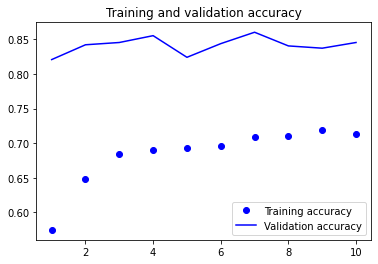

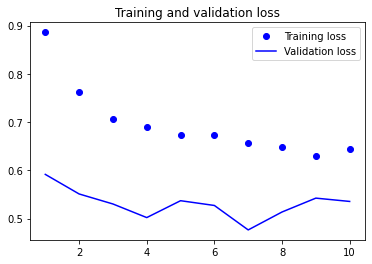

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

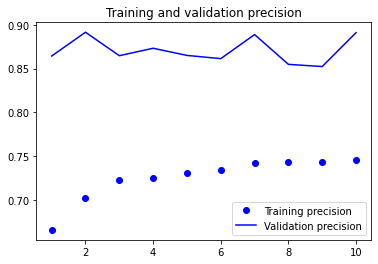

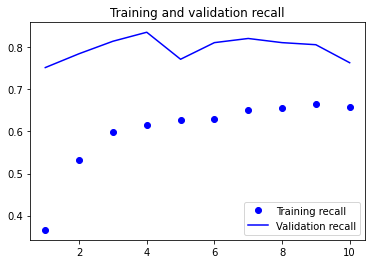

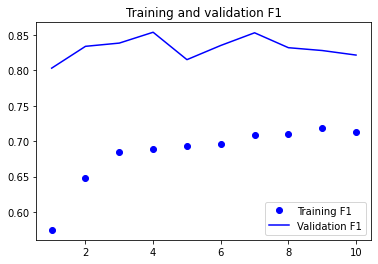

In [50]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

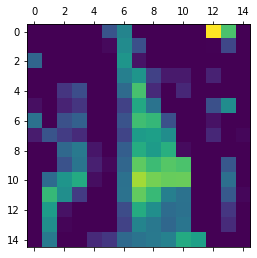

Predicted: [[0.97324216 0.00793053 0.01882729]]


In [51]:
img_path = "/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

preds = model.predict(img)

# todo: get those labels up
# order: normal, bacterial, viral
print("Predicted:", (preds))

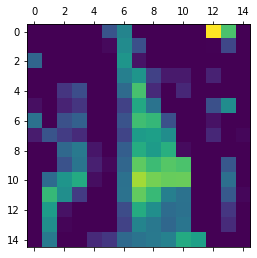

In [52]:
img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

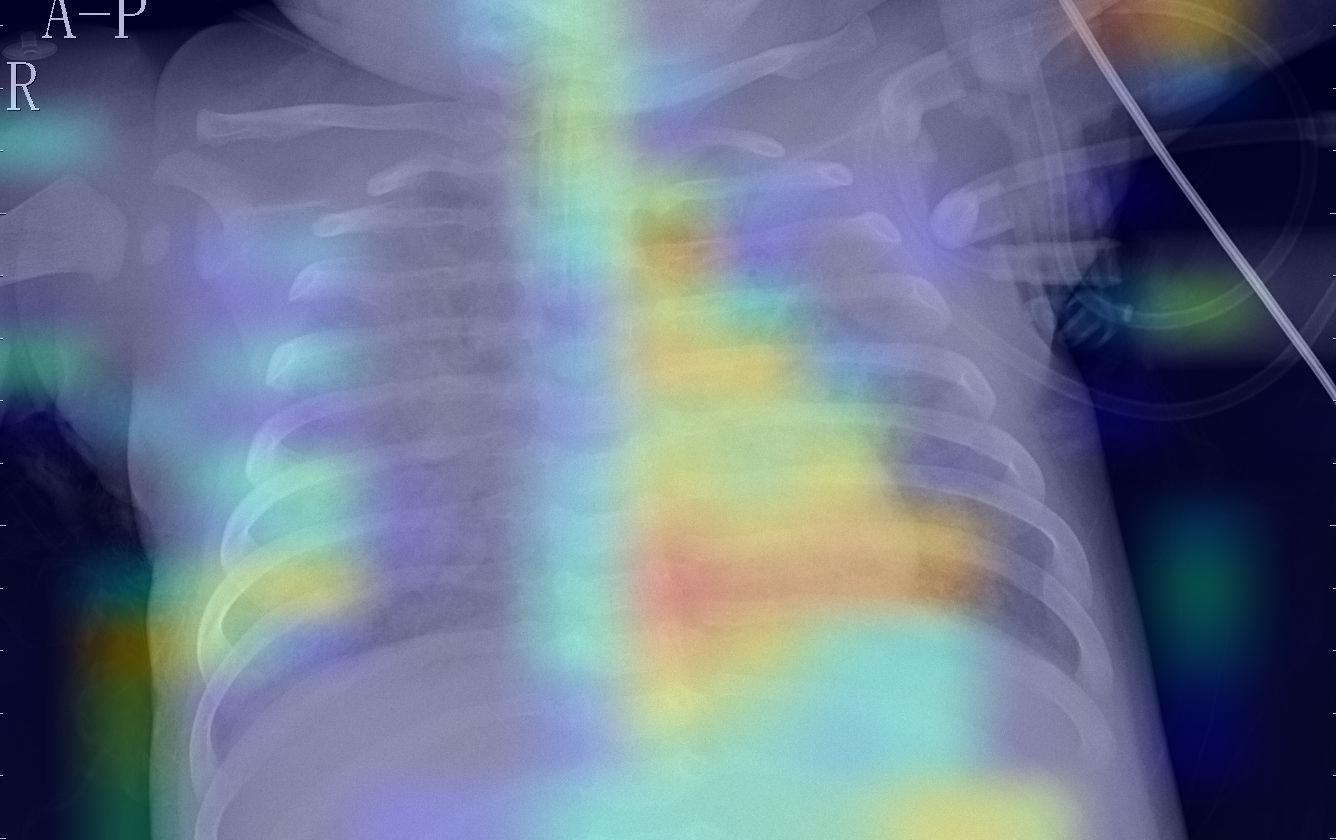

In [53]:
superimposition("/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg",heatmap,"three_way_bacteria_case.jpeg")

# MORE HEAT MAPS

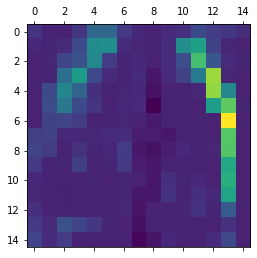

In [54]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [ ]:
#SALIENCY